# Semantic Segmentation
https://pytorch.org/docs/stable/torchvision/models.html

The models subpackage contains definitions for the following model architectures for semantic segmentation:
- FCN ResNet101
- DeepLabV3 ResNet101

As with image classification models, all pre-trained models expect input images normalized in the same way. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. They have been trained on images resized such that their minimum size is 520.

The pre-trained models have been trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset. You can see more information on how the subset has been selected in references/segmentation/coco_utils.py. The classes that the pre-trained model outputs are the following, in order:
~~~
['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
~~~

~~~
CAT_LIST = [0, 5, 2, 16, 9, 44, 6, 3, 17, 62, 21, 67, 18, 19, 4, 1, 64, 20, 63, 7, 72]
~~~

In [1]:
from torch.utils.data import DataLoader
from torchvision.datasets import CocoCaptions, CocoDetection
from torchvision import transforms
from pycocotools import mask
from pycocotools.coco import COCO
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn
import torch.optim as optim
import torch
from torch.utils import data
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torchvision
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
import os

In [4]:
os.listdir('/home/euloo/Documents/datasets/coco2017')

['test2017', 'image_info_test', 'val2017', 'annotations', 'train2017']

In [5]:
dataDir = '/home/euloo/Documents/datasets/coco2017'

trainDataType ="train2017"
trainAnnFile = "{}/annotations/instances_{}.json".format(dataDir,trainDataType)

valDataType = "val2017"
valAnnFile = "{}/annotations/instances_{}.json".format(dataDir,valDataType)

In [6]:
class Dataset(CocoDetection):
    def __init__(self, root, annFile, transforms=None, transform=None, target_transform=None):
        super().__init__(root, annFile, transforms, transform, target_transform)
        
        cats = self.coco.loadCats(self.coco.getCatIds()) 
        self.id_to_class, self.layer_to_name = {}, {}
        self.id_to_class[0] = 0
        self.layer_to_name[0] = 'background'
        for it, cat in enumerate(cats):
            self.id_to_class[cat['id']] = it+1
            self.layer_to_name[it+1] = cat['name']
        
    def __getitem__(self, index):
        img, ann = super().__getitem__(index)
        width, height = img.size[:2]
        msk = np.zeros((height, width))
        
        img_T = transforms.Compose(([
            transforms.Resize((height, width)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]))
        
        msk_T = transforms.Compose(([
            transforms.ToTensor()
        ]))
        
        for it in ann:
            compressed_rle = mask.frPyObjects(it['segmentation'], height, width)
            compressed_rle = compressed_rle if isinstance(compressed_rle, list) else [compressed_rle]
            bw = np.sum(mask.decode(compressed_rle), axis = 2).astype(bool)
            msk[bw] = self.id_to_class[it['category_id']]
            
        return img_T(img), msk_T(msk.reshape((height, width))).long()

In [7]:
trainDataType = '/home/euloo/Documents/datasets/coco2017/train2017'
valDataType = '/home/euloo/Documents/datasets/coco2017/val2017'

In [8]:
trainAnnFile

'/home/euloo/Documents/datasets/coco2017/annotations/instances_train2017.json'

In [9]:
valAnnFile

'/home/euloo/Documents/datasets/coco2017/annotations/instances_val2017.json'

In [10]:
train_set = Dataset(trainDataType, trainAnnFile)
val_set = Dataset(valDataType, valAnnFile)

loading annotations into memory...
Done (t=18.59s)
creating index...
index created!
loading annotations into memory...
Done (t=2.39s)
creating index...
index created!


In [11]:
train_set.__len__(), val_set.__len__()

(118287, 5000)

In [12]:
img, msk = val_set[0]
print(img.shape,msk.shape)

torch.Size([3, 426, 640]) torch.Size([1, 426, 640])


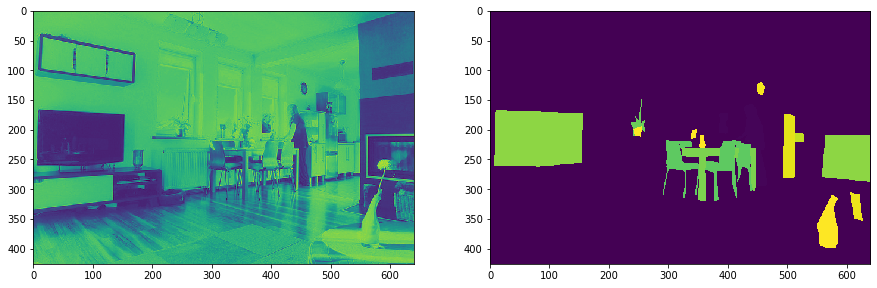

In [13]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(torchvision.utils.make_grid(img)[0,:,:])
plt.subplot(122)
plt.imshow(torchvision.utils.make_grid(msk)[0,:,:])

In [14]:
model = torchvision.models.segmentation.fcn_resnet101(pretrained=True)

In [15]:
model.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [16]:
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


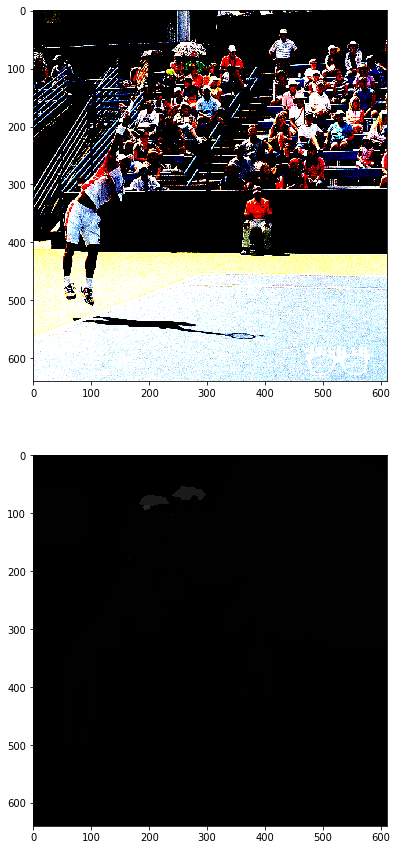

In [17]:
images, masks = next(iter(train_loader))
plt.figure(figsize=(15,15))
plt.subplot(211)
plt.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0))
plt.subplot(212)
plt.imshow(torchvision.utils.make_grid(masks).numpy().transpose(1,2,0))

In [51]:
torch.cuda.empty_cache()

In [18]:
%%time
model.eval()

with torch.no_grad():
    for i, data in enumerate(val_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)

CPU times: user 55min 26s, sys: 4min 27s, total: 59min 53s
Wall time: 10min 1s


In [19]:
!nvidia-smi

Thu Nov  7 21:25:00 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 107...  Off  | 00000000:22:00.0  On |                  N/A |
| 65%   75C    P2    45W / 180W |   2287MiB /  8112MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [20]:
out = outputs['out']
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
om

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
# Define the helper function
def decode_segmap(image, nc=21):
   
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
 
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
   
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
     
    rgb = np.stack([r, g, b], axis=2)
    return rgb

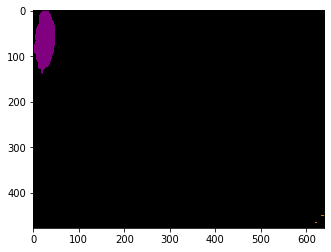

In [22]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


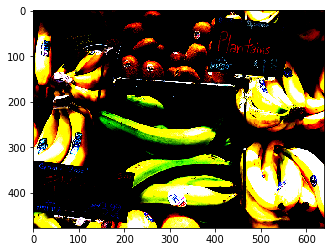

In [24]:
plt.imshow(np.transpose(inputs[0].cpu(), (1,2,0))); plt.show()

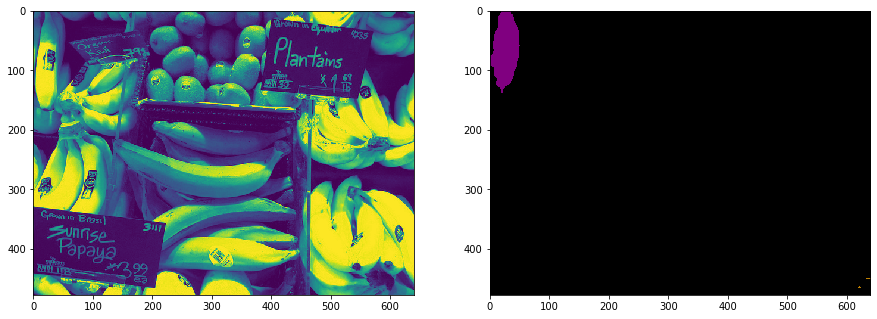

In [23]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(torchvision.utils.make_grid(inputs[0].cpu())[0,:,:])
plt.subplot(122)
plt.imshow(rgb)